In [1]:
cd .

c:\Users\jack.amy\mfm_libraries\rag_test


In [2]:
update = False

In [3]:
import utils
from resources.data import benchmark_sentences 

In [4]:
# import transformers
# print(transformers.__version__)

In [5]:
# import tensorflow as tf
import numpy as np

# print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)

NumPy version: 1.26.4


In [30]:
from einops import rearrange, repeat, einsum
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, AdamW
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
### other libs that speed things up 
import accelerate
# import flash_attn # currently only on linux 

RuntimeError: Failed to import transformers.optimization because of the following error (look up to see its traceback):
Couldn't build proto file into descriptor pool: duplicate symbol 'tensorflow.CoordinatedJob'

data_prep 

In [7]:
pdf_data = utils.pdf_to_text(r'resources\output.pdf')
text_data = utils.clean_and_split_text(pdf_data)
target_text = utils.get_random_members(text_data, 100, 40)

In [8]:
target_text[:10]

['Another consideration is around anti-trust cases against some of the large US technology companies',
 'Over the past few years, however, we’ve seen the deficit continue to widen even though the economy was robust',
 'That view seems well understood in financial markets',
 'In the past, investors have generally looked past the ratings downgrades and bond yields barely reacted',
 'Equity markets, particularly in the US, rose this week, continuing a recovery that really began after the US first announced a tariff delay (excluding China) on April 9th',
 'On the macro side, we are mindful that domestic demand in the US has slowed a bit',
 'Rating agencies have traditionally held a bit of a hybrid role in the financial system',
 'Currently investors only expect two 25 basis point cuts this year',
 'And the US is hardly alone in having higher debt to GDP',
 'In terms of growth, it looks like earnings grew around 13% year-on-year (not all companies have reported), the second consecutive quar

In [9]:

from transformers import AutoModelForCausalLM, AutoTokenizer

# Define the model name
model_name = 'microsoft/DialoGPT-medium'  # Example of a more updated model

# Load the model
device = 'cpu'  # Change to 'cuda' if using a GPU
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map=device,
    torch_dtype="auto",
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

print("Model and tokenizer loaded successfully!")

c:\Python311\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Python311\Lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_glob

Model and tokenizer loaded successfully!


In [10]:
len(benchmark_sentences)

100

In [11]:
comment_df = pd.DataFrame(columns=['benchmark', 'target', 'benchmark_embedded','target_embedded'])

comment_df['benchmark'] = benchmark_sentences[75:]
comment_df['target'] = target_text[75:]

In [17]:
if update:

    benchmark_embedded = utils.analyse_hidden_layers(comment_df, 'benchmark', model, tokenizer)
    target_embedded = utils.analyse_hidden_layers(comment_df, 'target', model, tokenizer)


    dict_to_save = {
        'benchmark_embedded': benchmark_embedded,
        'target_embedded': target_embedded
    }

In [18]:
if update:
    pd.to_pickle(dict_to_save, 'resources/embedded_comments_v1.pkl')

else:
    dict_to_save = pd.read_pickle('resources/embedded_comments_v1.pkl')
    benchmark_embedded = dict_to_save['benchmark_embedded']
    target_embedded = dict_to_save['target_embedded']


In [19]:
benchmark_embedded_list = [benchmark_embedded[i] for i in comment_df.index]
target_embedded_list = [target_embedded[i] for i in comment_df.index]

In [20]:
target_embedded[0].shape

torch.Size([1024])

In [22]:
# len(utils.get_comment_representation(target_embedded[0]))

In [23]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)

In [24]:
benchmark_avg = utils.aggregate_tensors(benchmark_embedded_list, method="mean")
target_avg = utils.aggregate_tensors(target_embedded_list, method="mean")

final_avg = utils.aggregate_tensors(benchmark_embedded_list + target_embedded_list, method="mean")


benchmark_avg_list = benchmark_avg.squeeze(0).tolist()
target_avg_list = target_avg.squeeze(0).tolist()
final_avg_list = final_avg.squeeze(0).tolist()

In [25]:
benchmark_avg_list_denoised = pd.Series(benchmark_avg_list) - pd.Series(final_avg_list)
target_avg_list_denoised = pd.Series(target_avg_list) - pd.Series(final_avg_list)


# apply L2 normalization to the denoised vectors - scale to unit length - not adding much tbh

benchmark_avg_list_denoised = benchmark_avg_list_denoised / np.linalg.norm(
    benchmark_avg_list_denoised
    )
target_avg_list_denoised = target_avg_list_denoised / np.linalg.norm(
    target_avg_list_denoised
    )


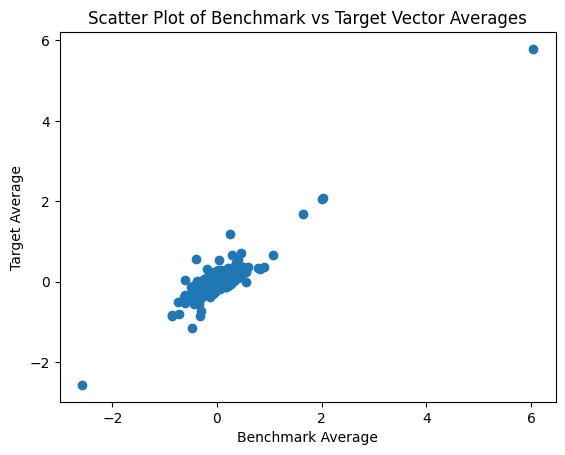

In [26]:
plt.scatter(
    x=benchmark_avg_list,
    y=target_avg_list,
)
plt.xlabel("Benchmark Average")
plt.ylabel("Target Average")
plt.title("Scatter Plot of Benchmark vs Target Vector Averages")


# plt.scatter(
#     x=benchmark_avg_list_denoised,
#     y=target_avg_list_denoised,
#     color='orange',
#     label='Denoised'
# )
# plt.xlabel("Benchmark Average")
# plt.ylabel("Target Average")
# plt.title("Scatter Plot of Denoised Benchmark vs Target Averages")

plt.show()

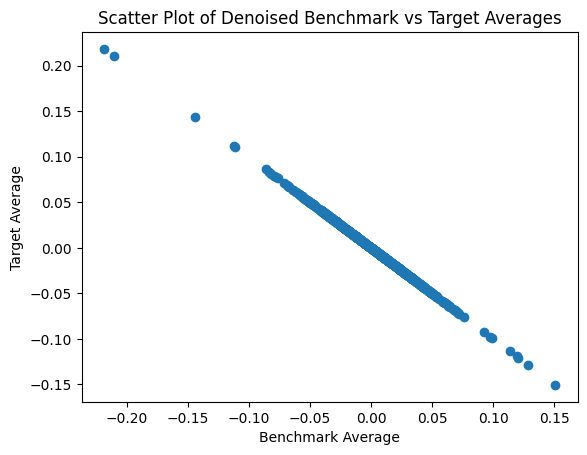

In [27]:
plt.scatter(
    x=benchmark_avg_list_denoised,
    y=target_avg_list_denoised,
)
plt.xlabel("Benchmark Average")
plt.ylabel("Target Average")
plt.title("Scatter Plot of Denoised Benchmark vs Target Averages")
plt.show();

In [28]:
### Reloading the model

In [29]:
model_name = 'microsoft/DialoGPT-medium'
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Ensure pad_token_id is set
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

# Prepare the data
target_text = [
    "The market is volatile today, with tech stocks leading the decline.",
    "Consumer spending has increased, signaling economic resilience.",
    # Add more sentences here...
]

# Tokenize the data
inputs = tokenizer(target_text, return_tensors="pt", padding=True, truncation=True)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = CrossEntropyLoss()

# Fine-tuning loop
model.train()
for epoch in range(3):  # Number of epochs
    optimizer.zero_grad()
    outputs = model(**inputs, labels=inputs["input_ids"])
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

# Save the fine-tuned model
model.save_pretrained(".resources/fine_tuned_dialoGPT")
tokenizer.save_pretrained(".resources/fine_tuned_dialoGPT")

c:\Python311\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Python311\Lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_glob

NameError: name 'AdamW' is not defined